# Interest Rate Risk and Yield Curve Modelling

As economic uncertainty runs throughout the country, interest rates are once again being scrutinized by financial professionals. However, as a Mathematical Finance student, the goal of this exploratory side project is to investigate interest rates through a more quantitative aspect rather than a future economic outlook aspect. We look at the US treasury yields at different maturities using zero coupon bonds and try to build a smooth curve to fit these interest rates. Then, given a bond and swap portfolio, the PnL of the portfolio as well as the interest rate risks captured by duration are presented.

#### Import necessary libraries

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from pandas_datareader import data as web
import datetime

#### Importing US treasury rates

In [4]:
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime.today()

tickers = {
    '1M': 'DGS1MO',
    '3M': 'DGS3MO',
    '6M': 'DGS6MO',
    '1Y': 'DGS1',
    '2Y': 'DGS2',
    '3Y': 'DGS3',
    '5Y': 'DGS5',
    '7Y': 'DGS7',
    '10Y': 'DGS10',
    '20Y': 'DGS20',
    '30Y': 'DGS30'
}



In [5]:
df_list = []
for label, series in tickers.items():
    df_temp = web.DataReader(series, 'fred', start, end)
    df_temp.rename(columns={series: label}, inplace=True)
    df_list.append(df_temp)
df_rates = pd.concat(df_list, axis=1)

print(df_rates)

              1M    3M    6M    1Y    2Y    3Y    5Y    7Y   10Y   20Y   30Y
DATE                                                                        
2015-01-01   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2015-01-02  0.02  0.02  0.11  0.25  0.66  1.07  1.61  1.92  2.12  2.41  2.69
2015-01-05  0.02  0.03  0.10  0.26  0.68  1.06  1.57  1.85  2.04  2.32  2.60
2015-01-06  0.02  0.03  0.10  0.25  0.65  1.02  1.50  1.78  1.97  2.25  2.52
2015-01-07  0.02  0.03  0.09  0.25  0.62  1.00  1.47  1.76  1.96  2.25  2.52
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
2025-08-22  4.47  4.27  4.08  3.87  3.68  3.64  3.76  3.98  4.26  4.84  4.88
2025-08-25  4.45  4.29  4.08  3.88  3.73  3.68  3.80  4.01  4.28  4.86  4.89
2025-08-26  4.42  4.28  4.06  3.85  3.61  3.63  3.75  3.98  4.26  4.86  4.90
2025-08-27  4.42  4.26  4.04  3.83  3.59  3.59  3.69  3.95  4.24  4.87  4.91
2025-08-28  4.42  4.26  4.04  3.85  3.62  3.60  3.69  3.92  4.22  4.83  4.88

#### Removing Closed Market Days

In [6]:
df_rates = df_rates.dropna(how='all')
print(df_rates.head())

              1M    3M    6M    1Y    2Y    3Y    5Y    7Y   10Y   20Y   30Y
DATE                                                                        
2015-01-02  0.02  0.02  0.11  0.25  0.66  1.07  1.61  1.92  2.12  2.41  2.69
2015-01-05  0.02  0.03  0.10  0.26  0.68  1.06  1.57  1.85  2.04  2.32  2.60
2015-01-06  0.02  0.03  0.10  0.25  0.65  1.02  1.50  1.78  1.97  2.25  2.52
2015-01-07  0.02  0.03  0.09  0.25  0.62  1.00  1.47  1.76  1.96  2.25  2.52
2015-01-08  0.01  0.03  0.08  0.23  0.62  1.00  1.50  1.81  2.03  2.33  2.59


#### Applying Nelson Siegel to Fit Interest Rates

In [11]:
yields = df_rates.loc['2025-07-17'].values / 100
maturities = np.array([1/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
def nelson_siegel(tau, beta0, beta1, beta2, lambd):
    term1 = (1 - np.exp(-tau / lambd)) / (tau / lambd)
    term2 = term1 - np.exp(-tau / lambd)
    return beta0 + beta1 * term1 + beta2 * term2
p0 = [0.03, -0.02, 0.02, 1.0]


In [12]:
params, covariance = curve_fit(
    nelson_siegel,
    maturities,
    yields,
    p0=p0,
    bounds=([0, -1, -1, 0.01], [0.2, 1, 1, 10])
)

beta0, beta1, beta2, lambd = params
print(f"Fitted parameters: beta0={beta0:.4f}, beta1={beta1:.4f}, beta2={beta2:.4f}, lambda={lambd:.4f}")



Fitted parameters: beta0=0.0541, beta1=-0.0092, beta2=-0.0347, lambda=2.2556


#### Plotting Term Structure

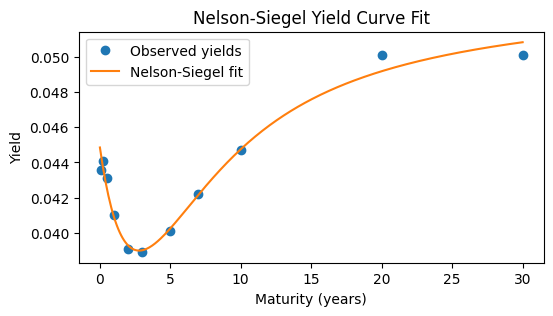

In [13]:
tau_plot = np.linspace(0.01, 30, 300)
y_fit = nelson_siegel(tau_plot, beta0, beta1, beta2, lambd)

plt.figure(figsize=(6,3))
plt.plot(maturities, yields, 'o', label='Observed yields')
plt.plot(tau_plot, y_fit, '-', label='Nelson-Siegel fit')
plt.xlabel('Maturity (years)')
plt.ylabel('Yield')
plt.title('Nelson-Siegel Yield Curve Fit')
plt.legend()
plt.show()

#### Applying Svensson Model 

Let us examine whether applying the Svensson Model, which adds another term to account for possibly more than one hump, gives us a similar curve to Nelson-Siegel

In [15]:
def svensson(tau, beta0, beta1, beta2, beta3, lambd1, lambd2):
    term1 = (1 - np.exp(-tau/lambd1)) / (tau/lambd1)
    term2 = term1 - np.exp(-tau/lambd1)
    term3 = (1 - np.exp(-tau/lambd2)) / (tau/lambd2) - np.exp(-tau/lambd2)
    
    return beta0 + beta1*term1 + beta2*term2 + beta3*term3
    
p0 = [0.04, -0.02, 0.02, 0.01, 1.0, 3.0] 
bounds = ([-1, -1, -1, -1, 0.01, 0.01],
          [ 1,  1,  1,  1, 10.0, 10.0])
params, cov = curve_fit(svensson, maturities, yields, p0=p0, bounds=bounds, maxfev=10000)

beta0, beta1, beta2, beta3, lambd1, lambd2 = params
print("Fitted parameters:", params)


Fitted parameters: [ 4.06472554e-02  4.03642468e-03 -3.76749730e-02  4.77237814e-02
  2.90019401e+00  9.99999966e+00]


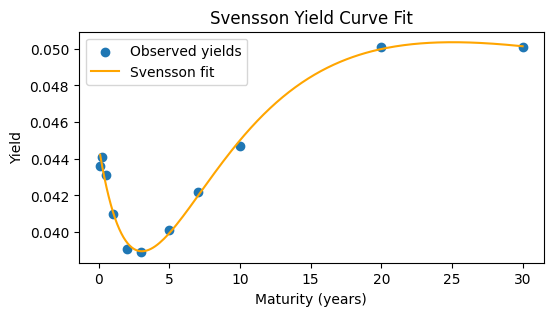

In [16]:
tau_grid = np.linspace(0.1, 30, 200)
plt.figure(figsize=(6,3))
plt.scatter(maturities, yields, label="Observed yields")
plt.plot(tau_grid, svensson(tau_grid, *params), color="orange", label="Svensson fit")
plt.xlabel("Maturity (years)")
plt.ylabel("Yield")
plt.title("Svensson Yield Curve Fit")
plt.legend()
plt.show()


We see that the Svensson model gives more curvature to the fit compared to the Nelson-Siegel model

### Interest Rate Risk Scenarios

To investigate interest rates through a quantitative perspective, we simulate changes to the interest rate and see the effects on our bond and swap portfolio

In [17]:
def df_from_yield_cont(y, t):
    # y in decimals (0.045 for 4.5%), t in years, continuous comp.
    return np.exp(-y * t)

def zs_from_model(tau, model_func, params):
    # model_func = your nelson_siegel or svensson function
    # returns zero yields y(tau) in decimals
    return model_func(np.asarray(tau), *params)

def discount_curve(times, model_func, params):
    ys = zs_from_model(times, model_func, params)
    return np.exp(-ys * np.asarray(times))


The above functions will help us price our bonds by bringing coupon and principal payments to present value by applying the appropriate discount rate which depends on the yield curve

In [31]:
def bond_cashflow_times(settle, maturity, freq):
    # simple ACT/365f-ish spacing in years for illustration
    n = int(np.round((maturity - settle) * freq))
    return settle + np.arange(1, n+1)/freq

def price_bond(face, coupon, freq, settle, maturity, model_func, params):
    # coupon & yield in decimals (0.03), times in years
    times = bond_cashflow_times(settle, maturity, freq)
    dfs = discount_curve(times, model_func, params)
    cpn_cf = face * coupon / freq
    pv_coupons = np.sum(cpn_cf * dfs)
    pv_principal = face * dfs[-1]
    return pv_coupons + pv_principal

def bond_dv01_fd(face, coupon, freq, settle, maturity, model_func, params, bp=1e-4):
    # finite-difference parallel bump
    base = price_bond(face, coupon, freq, settle, maturity, model_func, params)
    # bump: add +1bp to zero yields (implemented by tweaking model output)
    def bumped_model(tau, *p): return zs_from_model(tau, model_func, p) + bp
    bumped = price_bond(face, coupon, freq, settle, maturity, bumped_model, params)
    return base - bumped  # $/bp (positive for long-bond)

In [32]:
def swap_schedule(settle, maturity, freq):
    n = int(np.round((maturity - settle) * freq))
    pay_times = settle + np.arange(1, n+1)/freq
    accruals = np.full_like(pay_times, 1/freq, dtype=float)
    return pay_times, accruals

def swap_annuity(settle, maturity, freq, model_func, params):
    pay_times, accruals = swap_schedule(settle, maturity, freq)
    dfs = discount_curve(pay_times, model_func, params)
    return np.sum(dfs * accruals)

def par_swap_rate(settle, maturity, freq, model_func, params):
    pay_times, accruals = swap_schedule(settle, maturity, freq)
    dfs = discount_curve(pay_times, model_func, params)
    A = np.sum(dfs * accruals)
    return (1.0 - dfs[-1]) / A

def price_pay_fixed_swap(notional, fixed_rate, settle, maturity, freq, model_func, params):
    A = swap_annuity(settle, maturity, freq, model_func, params)
    S = par_swap_rate(settle, maturity, freq, model_func, params)
    # PV = (k - S) * A * N  (pay-fixed: positive if k > S)
    return (fixed_rate - S) * A * notional

def swap_dv01_fd(notional, fixed_rate, settle, maturity, freq, model_func, params, bp=1e-4):
    base = price_pay_fixed_swap(notional, fixed_rate, settle, maturity, freq, model_func, params)
    def bumped_model(tau, *p): return zs_from_model(tau, model_func, p) + bp
    bumped = price_pay_fixed_swap(notional, fixed_rate, settle, maturity, freq, bumped_model, params)
    return base - bumped  # pay-fixed DV01 is typically negative

The above functions help us price the swap and also help calculate the change in portfolio price based on a one basis point bump to interest rates over all maturities

In [33]:
p0 = [0.03, -0.02, 0.02, 1.0]

params, covariance = curve_fit(
    nelson_siegel,
    maturities,
    yields,
    p0=p0,
    bounds=([0, -1, -1, 0.01], [0.2, 1, 1, 10])
)

beta0, beta1, beta2, lambd = params
print(params)

[ 0.05413873 -0.00923118 -0.03474153  2.25557575]


In [34]:
model_func = nelson_siegel        

settle = 0.0  # "today" in years

bonds = [
    (4_000_000, 0.03, 2, settle, settle+2.0),   # 2Y
    (3_000_000, 0.035,2, settle, settle+5.0),   # 5Y
    (2_000_000, 0.04, 2, settle, settle+10.0),  # 10Y
]
# Swap: pay-fixed 5Y ~par
swap_notional = 7_000_000
swap_maturity = settle + 5.0
swap_freq = 2
swap_k = par_swap_rate(settle, swap_maturity, swap_freq, model_func, params) 

#### Calculating Bond Present Value and PnL after 1 basis point bump

In [35]:
bond_PVs = [price_bond(F, c, f, s, T, model_func, params) for (F,c,f,s,T) in bonds]
bond_DV01 = [bond_dv01_fd(F, c, f, s, T, model_func, params) for (F,c,f,s,T) in bonds]

# Swap
swap_PV = price_pay_fixed_swap(swap_notional, swap_k, settle, swap_maturity, swap_freq, model_func, params)
swap_DV01 = swap_dv01_fd(swap_notional, swap_k, settle, swap_maturity, swap_freq, model_func, params)

portfolio_PV = sum(bond_PVs) + swap_PV
portfolio_DV01 = sum(bond_DV01) + swap_DV01
print("Base PV:", portfolio_PV, "  Parallel DV01 ($/bp):", portfolio_DV01)


Base PV: 8775604.08874404   Parallel DV01 ($/bp): 6914.726048748465


In [36]:
def local_bump(times, t_key, width=3.0):  # years; width controls how wide the bump spreads
    times = np.asarray(times)
    w = np.maximum(0.0, 1.0 - np.abs(times - t_key)/width)  # triangle (0..1)
    return w

def krd(instrument_pricer, args_tuple, t_key, bp=1e-4):
    # instrument_pricer(model_func, params, *args) -> PV
    # Construct a bumped model that adds +bp * weight(t) to y(t)
    def bumped_model(tau, *p):
        tau = np.asarray(tau)
        bump = local_bump(tau, t_key) * bp
        return zs_from_model(tau, model_func, p) + bump
    base = instrument_pricer(model_func, params, *args_tuple)
    bumped = instrument_pricer(bumped_model, params, *args_tuple)
    return base - bumped

# Wrap pricers to match signature
def bond_pricer(mf, prms, F,c,f,s,T): return price_bond(F,c,f,s,T,mf,prms)
def swap_pricer(mf, prms, N,k,s,T,f): return price_pay_fixed_swap(N,k,s,T,f,mf,prms)

# Compute KRDs at 2y, 5y, 10y
keys = [2.0, 5.0, 10.0]
bond_KRDs = {k: sum(krd(bond_pricer, (F,c,f,s,T), k) for (F,c,f,s,T) in bonds) for k in keys}
swap_KRDs = {k: krd(swap_pricer, (swap_notional, swap_k, settle, swap_maturity, swap_freq), k) for k in keys}
portfolio_KRDs = {k: bond_KRDs[k] + swap_KRDs[k] for k in keys}
print("Portfolio KRDs ($/bp):", portfolio_KRDs)

Portfolio KRDs ($/bp): {2.0: np.float64(1017.9154681334226), 5.0: np.float64(4423.510440080365), 10.0: np.float64(1363.2021142272279)}


Next, we simulate various different shifts to the interest rate curve including a parallel shift, a steppening, a flatenning and a butterfly shift. Instead of calculating the exact change to the bond and swap portfolio, we use an estimation to the change PnL by using bond and swap duration as a proxy for estimation

In [37]:
def pnl_from_krd(portfolio_KRDs, scenario_bps):  # scenario_bps dict {2.0: +25, 5.0:+10, 10.0:+25}
    pnl = 0.0
    for k,v in scenario_bps.items():
        pnl += -(portfolio_KRDs[k] * v)   # minus sign (rates ↑ → prices ↓)
    return pnl

# Examples (bp moves at key rates)
parallel_25 = {2.0:25, 5.0:25, 10.0:25}
steepen = {2.0:-25, 5.0:10, 10.0:25}
flatten = {2.0:25, 5.0:10, 10.0:-25}
butterfly = {2.0:10, 5.0:-25, 10.0:10}

for name, sc in [("Parallel +25", parallel_25), ("Steepen", steepen), ("Flatten", flatten), ("Butterfly", butterfly)]:
    print(name, "P&L ($):", round(pnl_from_krd(portfolio_KRDs, sc), 2))


Parallel +25 P&L ($): -170115.7
Steepen P&L ($): -52867.27
Flatten P&L ($): -35602.94
Butterfly P&L ($): 86776.59


In [38]:
def scen_model(base_model, shift_fn):
    # returns a model_func(tau, *params) that adds shift(tau) in decimals
    def f(tau, *p):
        tau = np.asarray(tau)
        return base_model(tau, *p) + shift_fn(tau)
    return f

def make_parallel_shift(bp):
    bump = bp/1e4
    return lambda tau: np.full_like(np.asarray(tau), bump, dtype=float)

# Example: +25 bp parallel shift
shifted_model = scen_model(model_func, make_parallel_shift(25))
pv_shifted = sum(price_bond(F,c,f,settle,T, shifted_model, params) for (F,c,f,settle,T) in bonds) \
           + price_pay_fixed_swap(swap_notional, swap_k, settle, swap_maturity, swap_freq, shifted_model, params)
print("Exact parallel +25bp P&L:", round(pv_shifted - portfolio_PV, 2))


Exact parallel +25bp P&L: -171722.13
